In [0]:
!pip install moviepy

In [0]:

import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.image as mpimg
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Check images are correctly loading from google drive: 

Info:

*https://medium.com/meta-design-ideas/math-stats-and-nlp-for-machine-learning-as-fast-as-possible-915ef47ced5f*

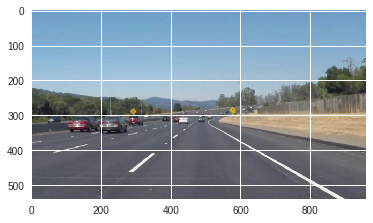

In [0]:
img = mpimg.imread('/content/drive/My Drive/colab/lane_finding/test_images/solidWhiteCurve.jpg')
plt.imshow(img)

Greyscale image


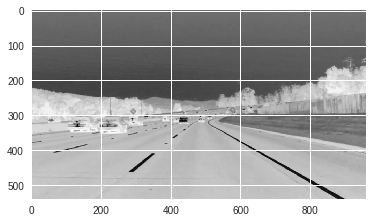

In [0]:
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(grey)

HSV Image


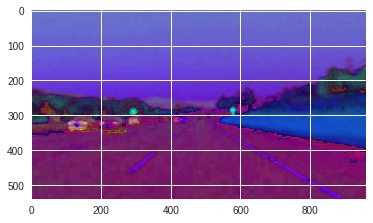

In [0]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
plt.imshow(img_hsv)

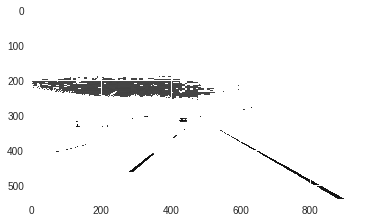

In [0]:
mask_white = cv2.inRange(grey, 200, 255)
mask_white_image = cv2.bitwise_and(grey, mask_white)
plt.imshow(mask_white_image)

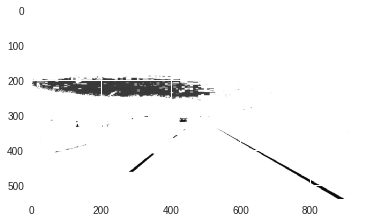

In [0]:
kernel_size = 5
gauss_grey = cv2.GaussianBlur(mask_white_image, (kernel_size, kernel_size), 0)
plt.imshow(gauss_grey)

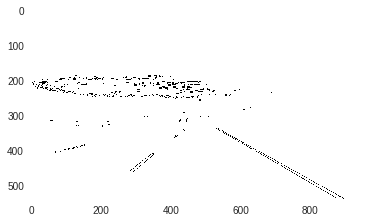

In [0]:
edges = cv2.Canny(gauss_grey,90,170)
plt.imshow(edges)

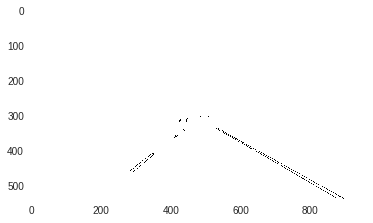

In [0]:
 height, width = edges.shape

#Create mask shape (max height is bottom of image)
vertices = [
    (0, height),
    (width / 2, height / 2),
    (width, height)]

#Create blank image the same size as original image
mask = np.zeros_like(edges)

match_mask_color = (255,) 

#Function that fills an area with the image 
cv2.fillPoly(mask, np.array([vertices], np.int32), match_mask_color)

masked_image = cv2.bitwise_and(edges, mask)

plt.imshow(masked_image)

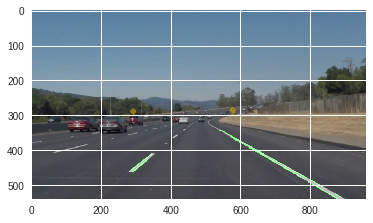

In [0]:


lines = cv2.HoughLinesP(masked_image, 1, np.pi/180, 50)

#     rho = 1
#     threshold = 50
#     min_line_len = 25
#     max_line_gap = 125

line_img = np.zeros(
    (
        img.shape[0],
        img.shape[1],
        3
    ),
    dtype=np.uint8,
)

for x in range(0, len(lines)):
    for x1,y1,x2,y2 in lines[x]:
        cv2.line(line_img,(x1,y1),(x2,y2),(0,255,0),2)

trial = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
plt.imshow(trial)

Seperating left and right lanes

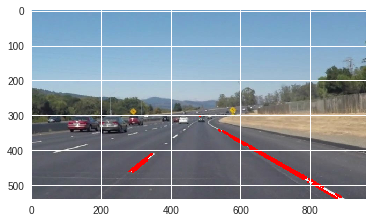

In [0]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=5, make_copy=True):
    # Copy the passed image
    img_copy = np.copy(img) if make_copy else img
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img_copy, (x1, y1), (x2, y2), color, thickness)
    
    return img_copy
  
  
plt.imshow(draw_lines(img, lines))

In [0]:
def separate_lines(lines, img):
    img_shape = img.shape
    
    middle_x = img_shape[1] / 2
    
    left_lane_lines = []
    right_lane_lines = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            dx = x2 - x1 
            if dx == 0:
                #Discarding line since we can't gradient is undefined at this dx
                continue
            dy = y2 - y1
            
            # Similarly, if the y value remains constant as x increases, discard line
            if dy == 0:
                continue
            
            slope = dy / dx
            
            epsilon = 0.1
            if abs(slope) <= epsilon:
                continue
            
            if slope < 0 and x1 < middle_x and x2 < middle_x:
                # Lane should also be within the left hand side of region of interest
                left_lane_lines.append([[x1, y1, x2, y2]])
            elif x1 >= middle_x and x2 >= middle_x:
                # Lane should also be within the right hand side of region of interest
                right_lane_lines.append([[x1, y1, x2, y2]])
    
    return left_lane_lines, right_lane_lines

IndentationError: ignored

Draw lines between 

In [0]:
def get_vertices_for_img(img):
    imshape = img.shape
    height = imshape[0]
    width = imshape[1]

    vert = None
    
    if (width, height) == (960, 540):
        region_bottom_left = (130 ,imshape[0] - 1)
        region_top_left = (410, 330)
        region_top_right = (650, 350)
        region_bottom_right = (imshape[1] - 30,imshape[0] - 1)
        vert = np.array([[region_bottom_left , region_top_left, region_top_right, region_bottom_right]], dtype=np.int32)
    else:
        region_bottom_left = (200 , 680)
        region_top_left = (600, 450)
        region_top_right = (750, 450)
        region_bottom_right = (1100, 650)
        vert = np.array([[region_bottom_left , region_top_left, region_top_right, region_bottom_right]], dtype=np.int32)

    return vert
  
  

def find_lane_lines_formula(lines):
    xs = []
    ys = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            xs.append(x1)
            xs.append(x2)
            ys.append(y1)
            ys.append(y2)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(xs, ys)
    
    # Remember, a straight line is expressed as f(x) = Ax + b. Slope is the A, while intercept is the b
    return (slope, intercept)

def trace_lane_line(img, lines, top_y, make_copy=True):
    A, b = find_lane_lines_formula(lines)
    vert = get_vertices_for_img(img)

    img_shape = img.shape
    bottom_y = img_shape[0] - 1
    # y = Ax + b, therefore x = (y - b) / A
    x_to_bottom_y = (bottom_y - b) / A
    
    top_x_to_y = (top_y - b) / A 
    
    new_lines = [[[int(x_to_bottom_y), int(bottom_y), int(top_x_to_y), int(top_y)]]]
    return draw_lines(img, new_lines, make_copy=make_copy)
    
  
def trace_both_lane_lines(img, left_lane_lines, right_lane_lines):
    vert = get_vertices_for_img(img)
    region_top_left = vert[0][1]
    
    full_left_lane_img = trace_lane_line(img, left_lane_lines, region_top_left[1], make_copy=True)
    full_left_right_lanes_img = trace_lane_line(full_left_lane_img, right_lane_lines, region_top_left[1], make_copy=False)
    
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    img_with_lane_weight =  cv2.addWeighted(img, 0.7, full_left_right_lanes_img, 0.3, 0.0)
    
    return img_with_lane_weight

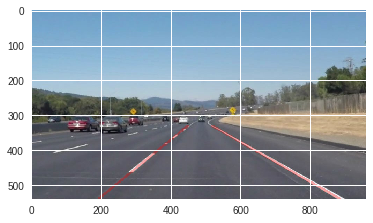

In [0]:
left_lane_lines, right_lane_lines = separate_lines(lines, img)
plt.imshow(trace_both_lane_lines(img,left_lane_lines, right_lane_lines))

In [0]:
def lane_det(img)

All together now

In [0]:
img = mpimg.imread('/content/drive/My Drive/colab/lane_finding/test_images/solidWhiteCurve.jpg')

def detect_lanes(img):
  grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
  lower_yellow = np.array([20, 100, 100], dtype = "uint8")
  upper_yellow = np.array([30, 255, 255], dtype="uint8")
  mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
  mask_white = cv2.inRange(grey, 200, 255)
  mask_yw = cv2.bitwise_or(mask_white, mask_yellow)
  mask_yw_image = cv2.bitwise_and(grey, mask_yw)

  kernel_size = 5
  gauss_grey = cv2.GaussianBlur(mask_yw_image, (kernel_size, kernel_size), 0)

  edges = cv2.Canny(gauss_grey,90,170)

  height, width = edges.shape

  #Create mask shape (max height is bottom of image)
  vertices = [
      (0, height),
      (width / 2, height / 2),
      (width, height)]

  #Create blank image the same size as original image
  mask = np.zeros_like(edges)

  match_mask_color = (255,)

  #Function that fills an area with the image 
  cv2.fillPoly(mask, np.array([vertices], np.int32), match_mask_color)

  masked_image = cv2.bitwise_and(edges, mask)



  lines = cv2.HoughLinesP(masked_image, 1, np.pi/180, 50)

  #     rho = 1
  #     threshold = 50
  #     min_line_len = 25
  #     max_line_gap = 125

  line_img = np.zeros(
      (
          img.shape[0],
          img.shape[1],
          3
      ),
      dtype=np.uint8,
  )

  for x in range(0, len(lines)):
      for x1,y1,x2,y2 in lines[x]:
          cv2.line(line_img,(x1,y1),(x2,y2),(0,255,0),2)

  trial = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
  return trial

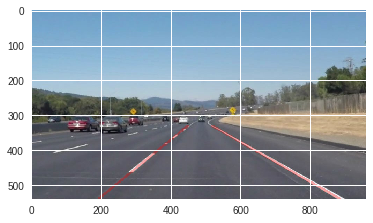

In [0]:
plt.imshow(detect_lanes(img))

In [0]:
first_frame = 1
white_output = '/content/drive/My Drive/colab/lane_finding.mp4'
clip1 = VideoFileClip("/content/drive/My Drive/colab/lane_finding/test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(detect_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video /content/drive/My Drive/colab/lane_finding.mp4
[MoviePy] Writing video /content/drive/My Drive/colab/lane_finding.mp4








  0%|          | 0/682 [00:00<?, ?it/s]





  0%|          | 3/682 [00:00<00:25, 26.18it/s]

ValueError: ignored